<a href="https://colab.research.google.com/github/emmelinetsen/Emerging_Technologies/blob/master/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Facenet: https://github.com/davidsandberg/facenet
Deeplab: https://github.com/tensorflow/models/tree/master/research/deeplab

https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

https://github.com/matterport/Mask_RCNN

# YOLOv3


In [10]:
import os
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import load_model, Model
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle
%matplotlib inline

Using TensorFlow backend.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

filename = '/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog_person.jpg'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


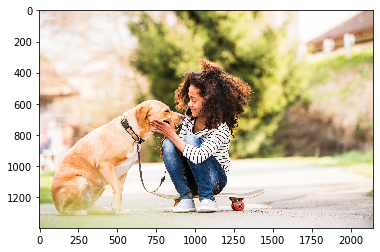

In [20]:
data = plt.imread(filename)
plt.imshow(data)

Creating a WeightReader class to load the pre-trained weights for YOLOv3. This class will parase the file and load the model weights into memory for the Keras model.

Adapted from https://github.com/experiencor/keras-yolo3/blob/master/yolo3_one_file_to_detect_them_all.py

In [0]:
class WeightReader():
  def __init__(self, file):
    with open(file, 'rb') as f:
      major,    = struct.unpack('i', f.read(4))
      minor,    = struct.unpack('i', f.read(4))
      revision, = struct.unpack('i', f.read(4))

      if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
        f.read(8)
      else:
        f.read(4)
      
      transpose = (major > 1000) or (minor > 1000)
      binary = f.read()
      self.offset = 0
      self.all_weights = np.frombuffer(binary, dtype='float32')


  def read_bytes(self, size):
    self.offset = self.offset + size
    return self.all_weights[self.offset-size:self.offset]

  def load_weights(self, model):
    for i in range(106):
      try:
        conv_layer = model.get_layer('conv_' + str(i))
        print("loading weights of convolution #" + str(i))
        
        if i not in [81, 93, 105]:
          norm_layer = model.get_layer('bnorm_' + str(i))
          size = np.prod(norm_layer.get_weights()[0].shape)
          beta  = self.read_bytes(size) # bias
          gamma = self.read_bytes(size) # scale
          mean  = self.read_bytes(size) # mean
          var   = self.read_bytes(size) # variance
          weights = norm_layer.set_weights([gamma, beta, mean, var])
        
        if len(conv_layer.get_weights()) > 1:
          bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
          kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))    
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel, bias])
        else:
          kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
          kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
          kernel = kernel.transpose([2,3,1,0])
          conv_layer.set_weights([kernel])
      except ValueError:
        print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

Create and save the YOLOv3 model

In [0]:
def conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [0]:
def yolov3():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

In [36]:
# define the model
model = yolov3()

# load the model weights
weightReader = WeightReader('/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/yolov3.weights')

# set the model weights into the model
weightReader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [0]:
# save model
model.save('/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/model.h5')

Making predictions from the saved yolov3 model

In [38]:
# load model
model = load_model('/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/model.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

In [0]:
# load image with required size
img = load_img('/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog_person.jpg', target_size=(416,416))
width, height = img.size

In [46]:
print(width, height)  

416 416


In [0]:
# convert to numpy array
img = img_to_array(img)

# scale pixel values to [0, 1]
img = img.astype('float32')
img /= 255.0

In [48]:
# scaled pixel data
print(img)

[[[0.90588236 0.84705883 0.81960785]
  [0.9137255  0.84705883 0.8156863 ]
  [0.90588236 0.827451   0.7921569 ]
  ...
  [0.7490196  0.6156863  0.5764706 ]
  [0.7647059  0.6313726  0.5921569 ]
  [0.7921569  0.6666667  0.62352943]]

 [[0.91764706 0.8666667  0.84313726]
  [0.90588236 0.84705883 0.81960785]
  [0.9098039  0.84313726 0.8117647 ]
  ...
  [0.7607843  0.627451   0.5882353 ]
  [0.78431374 0.6509804  0.6117647 ]
  [0.79607844 0.67058825 0.627451  ]]

 [[0.9137255  0.8627451  0.8392157 ]
  [0.9098039  0.85882354 0.8352941 ]
  [0.9098039  0.8352941  0.80784315]
  ...
  [0.76862746 0.63529414 0.59607846]
  [0.78039217 0.654902   0.6117647 ]
  [0.8        0.6745098  0.6313726 ]]

 ...

 [[0.7529412  0.78431374 0.56078434]
  [0.7490196  0.78431374 0.5372549 ]
  [0.7411765  0.7764706  0.52156866]
  ...
  [0.7607843  0.72156864 0.7176471 ]
  [0.75686276 0.7137255  0.7058824 ]
  [0.76862746 0.7254902  0.7176471 ]]

 [[0.75686276 0.7882353  0.5568628 ]
  [0.73333335 0.76862746 0.5058824 ]


Creating a method that takes in a filename and shape and returns the scaled  pixel data of the image as well as the original width and height of the image 

The original photo is used to scale the bounding boxes of all detected objects from the square shape back to the original shape

In [0]:
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	img = load_img(filename)
	width, height = img.size

	# load the image with the required size
	img = load_img(filename, target_size=shape)
	# convert to numpy array
	img = img_to_array(img)
	# scale pixel values to [0, 1]
	img = img.astype('float32')
	img /= 255.0

	# add a dimension so that we have one sample
	img = expand_dims(img, 0)
	return img, width, height

In [0]:
# load and prepare image
img, img_width, img_height = load_image_pixels('/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog_person.jpg', (416,416))


Now making a prediction with the input image through the yolov3 model

In [65]:
# make a prediction
yolo = model.predict(img)

# the output of this model is encoded candidate bounding boxes from 3 different grid sizes
print([x.shape for x in yolo])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [0]:
from matplotlib.patches import Rectangle

# creating class Box to define the corners of each bounding box in the 
# context of the input img shape and class prob
class Box:
 def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
  self.xmin = xmin
  self.ymin = ymin
  self.xmax = xmax
  self.ymax = ymax
 
  self.objness = objness
  self.classes = classes
  self.label = -1
  self.score = -1

In [0]:
def sigmoid(x):
  return 1./(1. + np.exp(-x))

# creating method to iterate through the arrays
# and decode the candidate bounding boxes and class predictions based on the object threshold
def decode(out, anchors, threshold, img_height, img_width):
    grid_height, grid_width = out.shape[:2]
    num_box = 3
    out = out.reshape((grid_height, grid_width, num_box, -1))
    nb_class = out.shape[-1] - 5

    boxes = []

    out[..., :2] = sigmoid(out[...,:2])
    out[..., 4:] = sigmoid(out[...,4:])
    out[..., 5:] = out[...,4][...,np.newaxis] * out[...,5:]
    out[..., 5:] *= out[...,5:] > threshold


    for i in range(grid_height * grid_width):
      row = i / grid_width
      col = i % grid_width
      
      for b in range(num_box):
        # 4th element is object-ness score
        obj = out[int(row)][int(col)][b][4]
        
        if (obj.all() <= threshold): continue

        # first 4 elements are x, y, w, and h
        x, y, w, h = out[int(row)][int(col)][b][:4]

        x = (col + x) / grid_width # center position, unit : img width
        y = (row + y) / grid_height # center position, unit: img height
        w = anchors[2 * b + 0] * np.exp(w) / img_width # unit: img width
        h = anchors[2 * b + 1] * np.exp(h) / img_height # unit: img height

        # last elements are class probabilities
        classes = out[int(row)][col][b][5:]
        box = Box(x-w/2, y-h/2, x+w/2, y+h/2, obj, classes)

        boxes.append(box)
    return boxes



In [0]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			#print("cl: ", classes)
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [0]:
def iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union


In [0]:
  def nonmax_suppression(boxes, threshold):
    if len(boxes) > 0:
      cl = len(boxes[0].classes)
    else:
      return
    for c in range(cl):
      sorted_indices = np.argsort([-box.classes[c] for box in boxes])
      for i in range(len(sorted_indices)):
        index_i = sorted_indices[i]
        if boxes[index_i].classes[c] == 0: continue
        for j in range(i+1, len(sorted_indices)):
          index_j = sorted_indices[j]
          if iou(boxes[index_i], boxes[index_j]) >= threshold:
            boxes[index_j].classes[c] = 0

In [0]:
  # returns parallel lists of boxes, labels, and scores
  def get_boxes(boxes, labels, threshold):
      v_boxes, v_labels, v_scores = list(), list(), list()
      # enumerate all boxes
      for box in boxes:
          # enumerate all possible labels
          for i in range(len(labels)):
              # check if the threshold for this label is high enough
              if box.classes[i] > threshold:
                  v_boxes.append(box)
                  v_labels.append(labels[i])
                  v_scores.append(box.classes[i]*100)
                  # don't break, many labels may trigger for one box
      return v_boxes, v_labels, v_scores

In [0]:
# need to change the bounding boxes back into the original image
    def original_box(boxes, image_h, image_w, net_h, net_w):
      if (float(net_w)/image_w) < (float(net_h)/image_h):
          new_w = net_w
          new_h = (image_h*net_w)/image_w
      else:
          new_h = net_w
          new_w = (image_w*net_h)/image_h
          
      for i in range(len(boxes)):
          x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
          y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
          
          boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
          boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
          boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
          boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)


In [0]:
 def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = plt.imread(filename)
    
    # plot the image
    plt.imshow(data)
    
    # get the context for drawing boxes
    ax = plt.gca()
    
    # plot each box
    for i in range(len(v_boxes)):
      box = v_boxes[i]
      # get coordinates
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
      # calculate width and height of the box
      width, height = x2 - x1, y2 - y1
      # create the shape
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      # draw the box
      ax.add_patch(rect)
      # draw text and score in top left corner
      label = "%s (%.3f)" % (v_labels[i], v_scores[i])
      plt.text(x1, y1, label, color='red')
        # show the plot
      plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.92145299911499
dog 99.31989908218384
skateboard 94.09105181694031


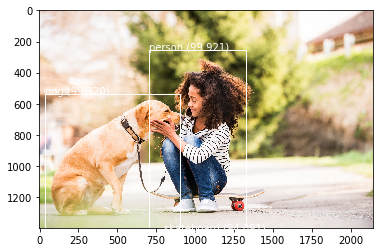

In [178]:
# load yolov3 model
model = load_model('/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/model.h5')

input_height, input_weight = 416, 416
# load and prepare image
image, image_w, image_h = load_image_pixels(filename, (input_height, input_weight))

# make prediction
y = model.predict(image)

# summarize the shape of the list of arrays
print([a.shape for a in y])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects

class_threshold = 0.6
boxes = list()
for i in range(len(y)):
	# decode the output of the network
	boxes += decode(y[i][0], anchors[i], class_threshold, input_height, input_weight)
 

# correct the sizes of the bounding boxes for the shape of the image
original_box(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
nonmax_suppression(boxes, 0.5)


# define the labels from COCO dataset
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(filename, v_boxes, v_labels, v_scores)

# DeepLab+

In [0]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

These helper methods help us perform the following tasks:


*   Load the latest version of the pretrained DeepLab model

*   Load the colormap from the PASCAL VOC dataset

*   Adds colors to various labels, such as "pink" for people, "green" for bicycle and more

*   Visualize an image, and add an overlay of colors on various regions

In [0]:
class DeepLab(object):

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  # create and load pretrained deeplab model
  def __init__(self, tarball_path):
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  # run inference on single image
  # takes in a PIL.Image object as the raw input image
  # returns a resized image that's in RGB image resized from the original input
  # and returns a segmentation map of the resized image
  def run(self, image):
    width, height = image.size
    ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(ratio * width), int(ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

# create colormap used in PASCAL VOC segmentation benchmark
# returns colormap that visualizes segmentation results
def pascal_colormap():

  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap

# adds color defined by the dataset colormap to the label
# takes in a 2D int array that stores the segmentation label
# returns 2D float array - element of the array is the color indexed by the corresponding 
# element in input label to PASCAL color map
def label_to_color_img(label):

  # if label is not 2D
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = pascal_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

# visualize input image, sementation map, and overlay view
def visualize(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_img(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_img(FULL_LABEL_MAP)

In [27]:
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('Downloading model')

# selecting pretrained deeplab+ model
urllib.request.urlretrieve('http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)
print('Loading DeepLab model...')

MODEL = DeepLab(download_path)
print('Model loaded successfully!')

Loading DeepLab model...
Model loaded successfully!


running deeplab on image /content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog_person.jpg...


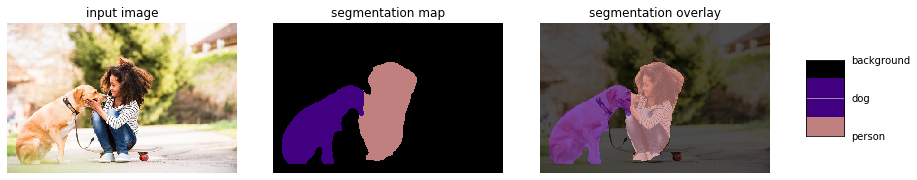

In [28]:
def run_visualization(filename):
  img = load_img(filename)
  print('running deeplab on image %s...' % filename)
  resized_im, seg_map = MODEL.run(img)
  visualize(resized_im, seg_map)


filename = '/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/dog_person.jpg'
run_visualization(filename)

# FaceNet

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [3]:
# loading pretrained facenet model
model = load_model('/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/facenet_keras.h5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y



In [0]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output



In [0]:
def load_and_align_images(filepaths, margin):
  # frontal face detector
    cascade = cv2.CascadeClassifier('/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/haarcascade_frontalface_alt2.xml')
    
    aligned_images = []
    for filepath in filepaths:
        print(filepath)
        img = imread(filepath)
        data = plt.imread(filepath)
        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        print(faces)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)


In [0]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [0]:
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        embs_ = calc_embs(filepaths)    
        labels.extend([name] * len(embs_))
        embs.append(embs_)
        
    embs = np.concatenate(embs)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='linear', probability=True).fit(embs, y)
    return le, clf

In [0]:
def infer(le, clf, filepaths):
    embs = calc_embs(filepaths)
    pred = le.inverse_transform(clf.predict(embs))
    return pred

In [0]:
image_dir_basepath = '/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/images/'
names = ['SteveCarell','ArianaGrande']
image_size = 160

In [61]:
le, clf = train(image_dir_basepath, names)


/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/images/SteveCarell/steve_02.jpg
[[ 7 35 70 70]]
/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/images/SteveCarell/steve_01.jpg
[[407 305 635 635]]
/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/images/ArianaGrande/ariana_0000.jpg
[[256  78  99  99]
 [ 66 250  31  31]]
/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/images/ArianaGrande/ariana_0002.jpg
[[372  80 165 165]]


In [0]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [81]:
pred = infer(le, clf, test_filepaths)


/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/images/Test/test01.jpg
[[302 150 281 281]]
/content/drive/My Drive/CMPE 278-98 - Emerging Technologies/Homework/images/Test/test02.jpg
[[ 925  260  390  390]
 [ 414 1088   45   45]]


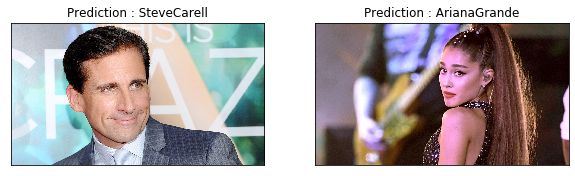

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    axes[i].set_title('Prediction : '+str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()